# Cancellation Rate Benchamarks

sql

In [ ]:
# select
#     tasks.id as task_id,
#     merchants.id as merchant_id,
#     status,
#     case
#         when status = 4 then null
#         when wp1.checkin_time is null and wp2.checkin_time is not null then 'At Client'
#         when wp1.checkin_time is null then 'Before Departure'
#         when wp1.checkin_time is not null and wp2.checkin_time is null then 'During Route'
#         when wp2.checkin_time is not null then 'At Client'
#     else 'unknown' end as cancelletion_stage 
# from tasks
# join merchants on tasks.merchant_id = merchants.id and subscription_type = 17
# left join way_points as wp1 on tasks.id = wp1.task_id and wp1.date >= 20250101
#     and (
#         (tasks.task_type_id = 2 and wp1.pickup_dropoff_option in (1,2)) OR
#         (tasks.task_type_id in (4,5) and wp1.pickup_dropoff_option = 0) OR
#         (merchants.partner_id = 875 and wp1.position = 2)
#   )
#  left join way_points as wp2 on tasks.id = wp2.task_id and wp2.date >= 20250101
#     and (
#         (tasks.task_type_id = 2 and wp2.pickup_dropoff_option = 0) OR
#         (tasks.task_type_id in (4,5) and wp2.pickup_dropoff_option in (1,2)) OR
#         (merchants.partner_id = 875 and wp2.position = 1)
#   )
#  where
#     tasks.date >= 20250101
#     and date(tasks.ended_time) between date '2025-04-01' and date '2025-04-30'
#     and status in (4,7)
#     and task_type_id <> 3
#     and is_billable = 1
  



## PreProcess

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick # Import this module

In [67]:
df1 = pd.read_csv('/Users/along/Documents/Analysis/Benchmarks/cancelus2.csv').sample(frac=0.1)
df2 = pd.read_csv('/Users/along/Documents/Analysis/Benchmarks/cancelus3.csv').sample(frac=0.1)
df3 = pd.read_csv('/Users/along/Documents/Analysis/Benchmarks/canceleu2.csv').sample(frac=0.1)
df4 = pd.read_csv('/Users/along/Documents/Analysis/Benchmarks/canceleu3.csv').sample(frac=0.1)
accounts = pd.read_csv('/Users/along/Documents/Analysis/Benchmarks/accounts.csv')

In [68]:
df_sample = pd.concat([df1,df2,df3,df4],
                       keys=['prod_us2','production','prod_eu2','prod_eu3']).merge(accounts, on=['merchant_id'],how='left').set_index('task_id')
df_sample.head()

,merchant_id,status,cancelletion_stage,env,name,industry,use_case
task_id,,,,,,,
494934279,6,4,NaN,prod_us2,AutoZone,General Retail,On-Demand Parcel
498333905,6,4,NaN,prod_us2,AutoZone,General Retail,On-Demand Parcel
498663103,3,7,Before Departure,prod_us2,AutoZone,General Retail,On-Demand Parcel
498965160,6,7,Before Departure,prod_us2,AutoZone,General Retail,On-Demand Parcel
502121133,6,4,NaN,prod_us2,AutoZone,General Retail,On-Demand Parcel


In [63]:
def get_metrics(group):
  status = group['status']
  stage = group['cancelletion_stage'] # Correcting typo in column name

  total_tasks = status.count()
  cancelled_tasks = status.where(status == 7).count()
  cancelled_before_departure = status.where((status == 7) & (stage == 'Before Departure')).count()
  cancelled_during_route = status.where((status == 7) & (stage == 'During Route')).count()
  cancelled_at_client = status.where((status == 7) & (stage == 'At Client')).count()

  return pd.Series({'total_tasks' : total_tasks,
                    'cancelled_ratio' : cancelled_tasks/total_tasks,
                    'cancelled_before_departure' : cancelled_before_departure / cancelled_tasks,
                    'cancelled_during_route' : cancelled_during_route / cancelled_tasks,
                    'cancelled_at_client' : cancelled_at_client / cancelled_tasks})

In [81]:
merchant_cancel = df_sample.groupby('name')[['status','cancelletion_stage']].apply(get_metrics)
merchant_cancel = merchant_cancel[merchant_cancel['total_tasks'] > 500]

industry_cancel = df_sample.groupby('industry')[['status','cancelletion_stage']].apply(get_metrics)

use_case_cancel = df_sample[df_sample['use_case'] != 'Missing'].groupby('use_case')[['status','cancelletion_stage']].apply(get_metrics)

merchant_cancel.style.format({'total_tasks' : '{:,.0f}', 'cancelled_ratio' : '{:.0%}', 'cancelled_before_departure' : '{:.0%}', 'cancelled_during_route' : '{:.0%}', 'cancelled_at_client' : '{:.0%}'})

,total_tasks,cancelled_ratio,cancelled_before_departure,cancelled_during_route,cancelled_at_client
name,,,,,
AAA,"37,489",5%,96%,0%,4%
ADEO,"22,723",5%,82%,12%,5%
AnyVan,"2,886",11%,88%,0%,12%
Armour Courier Services Inc.,"14,533",6%,85%,0%,15%
Asda,"15,960",13%,99%,0%,1%
AutoZone,"903,869",49%,100%,0%,0%
Best Buy,"63,164",41%,95%,0%,5%
Boulanger,"13,016",13%,72%,6%,21%
Burger King Corp (RBI),"22,517",1%,69%,25%,6%


## Visualization

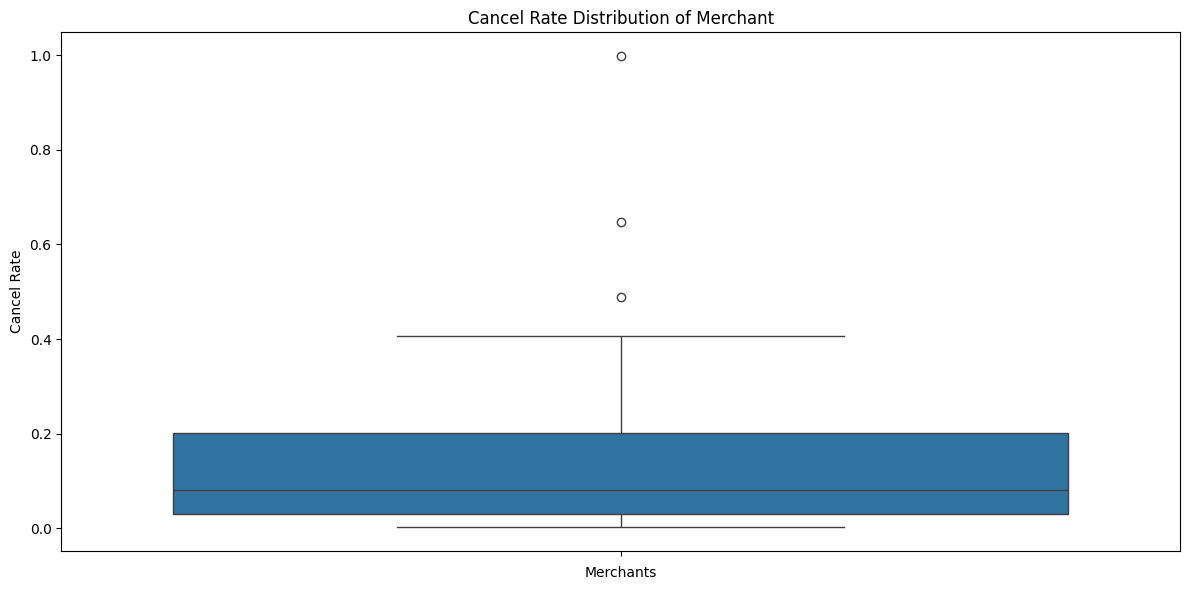

In [82]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=merchant_cancel, y='cancelled_ratio')

plt.xticks(rotation=45, ha='right')
plt.title('Cancel Rate Distribution of Merchant')
plt.xlabel('Merchants')
plt.ylabel('Cancel Rate')
plt.tight_layout()
plt.show()

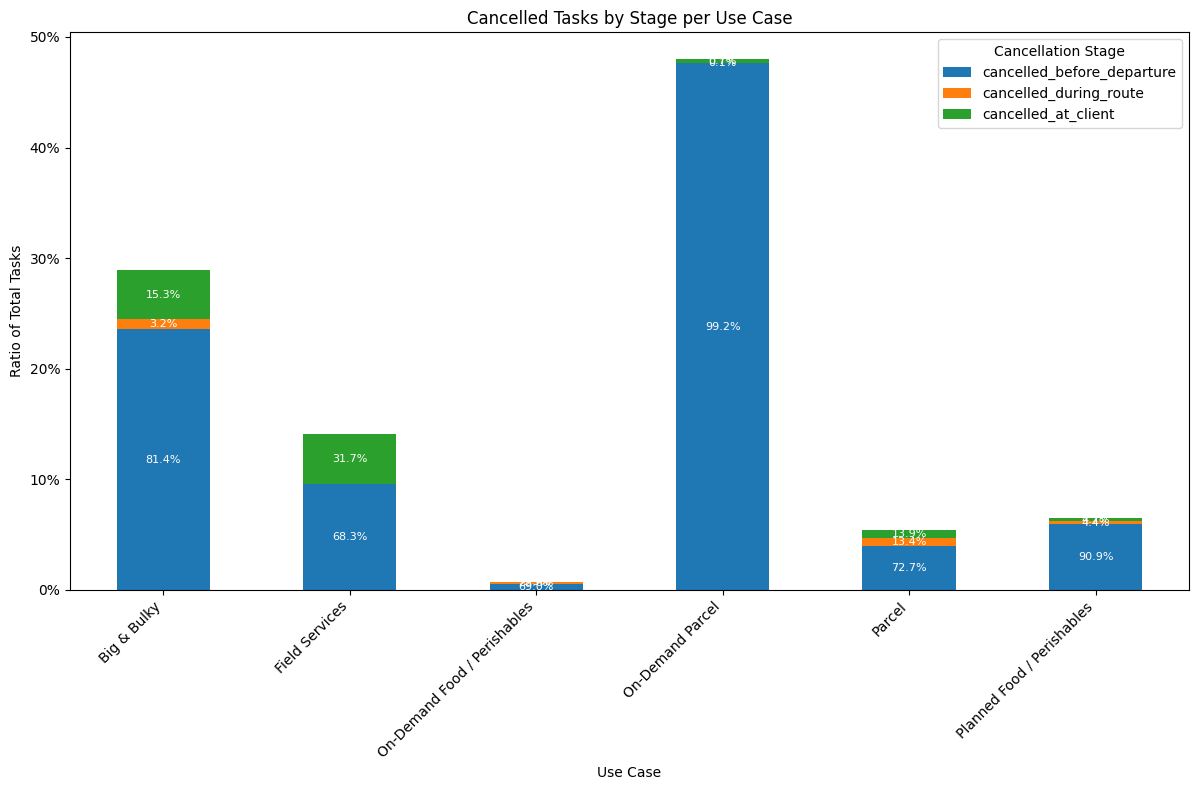

In [72]:

df_plot = use_case_cancel[['cancelled_before_departure', 'cancelled_during_route', 'cancelled_at_client']].mul(use_case_cancel['cancelled_ratio'], axis=0)
ax = df_plot.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Cancelled Tasks by Stage per Use Case')
plt.xlabel('Use Case')
plt.ylabel('Ratio of Total Tasks')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cancellation Stage')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Add annotations to the bars
for container_index, container in enumerate(ax.containers): # Use enumerate for container index
    column_name = df_plot.columns[container_index] # Get column name based on container index
    for i, patch in enumerate(container.patches):
        height = patch.get_height()
        if height > 0: # Only annotate non-zero height bars
            x, y = patch.get_xy()
            # Determine the value to display using the original use_case_cancel
            value = use_case_cancel.iloc[i][column_name]

            ax.text(x + patch.get_width() / 2.,
                    y + height / 2.,
                    f'{value:.1%}', # Format as percentage with 1 decimal place
                    ha='center',
                    va='center',
                    color='white', # Text color
                    fontsize=8)

plt.show()

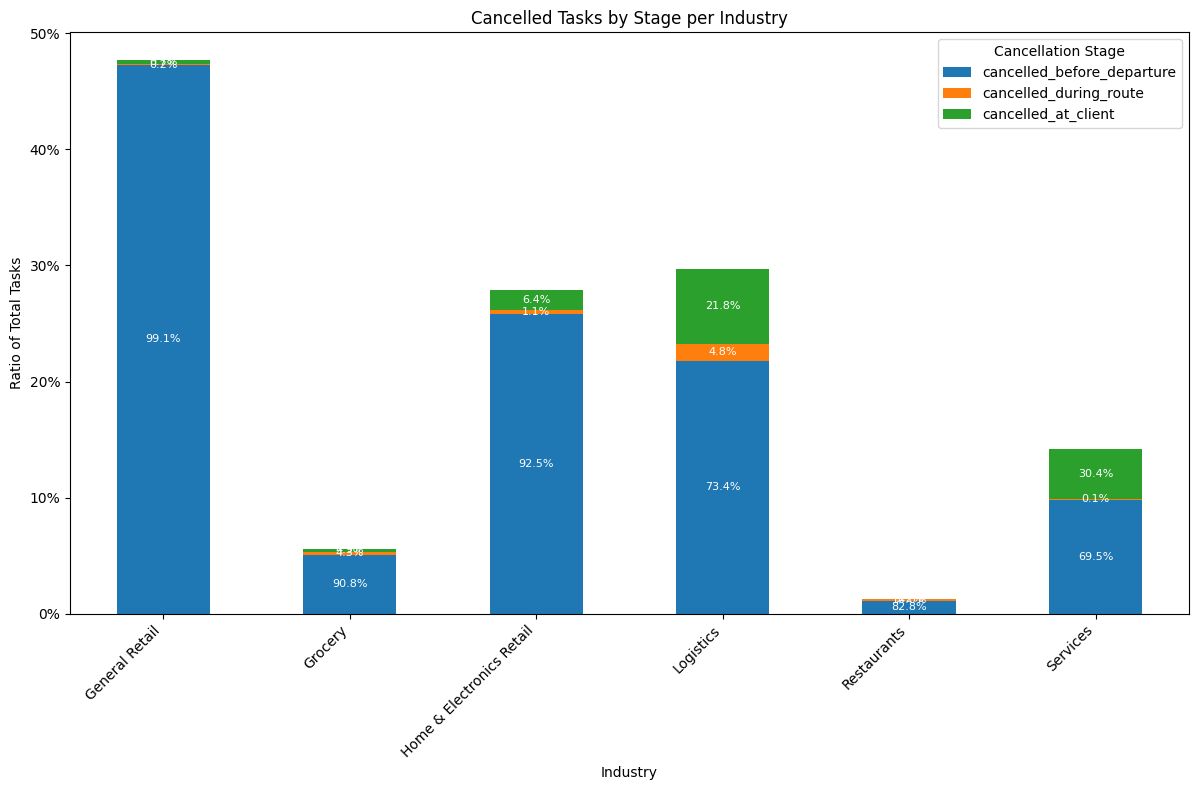

In [73]:
df_plot = industry_cancel[['cancelled_before_departure', 'cancelled_during_route', 'cancelled_at_client']].mul(industry_cancel['cancelled_ratio'], axis=0)
ax = df_plot.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Cancelled Tasks by Stage per Industry')
plt.xlabel('Industry')
plt.ylabel('Ratio of Total Tasks')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cancellation Stage')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Add annotations to the bars
for container_index, container in enumerate(ax.containers): # Use enumerate for container index
    column_name = df_plot.columns[container_index] # Get column name based on container index
    for i, patch in enumerate(container.patches):
        height = patch.get_height()
        if height > 0: # Only annotate non-zero height bars
            x, y = patch.get_xy()
            # Determine the value to display using the original industry_cancel
            value = industry_cancel.iloc[i][column_name]

            ax.text(x + patch.get_width() / 2.,
                    y + height / 2.,
                    f'{value:.1%}', # Format as percentage with 1 decimal place
                    ha='center',
                    va='center',
                    color='white', # Text color
                    fontsize=8)

plt.show()